In [1]:
import numpy as np
from enum import IntEnum, Enum
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import Nystroem, RBFSampler

In [2]:
class Action(Enum):
  UP = 'U'
  DOWN = 'D'
  LEFT = 'L'
  RIGHT = 'R'

  def __str__(self):
    return str(self.value)

In [3]:
class State(IntEnum):
  ACCESSIBLE_GRID = 0
  INACCESSIBLE_GRID = -2
  LOSER_GRID = -1
  WINNER_GRID = 1

In [4]:
ACTION_SPACE = (Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT)
STATE_PROBS = [0.6, 0.35, 0.05] # prob of accessible grid, prob of inaccessible grid, prob of loser grid
STATES = [State.ACCESSIBLE_GRID, State.INACCESSIBLE_GRID, State.LOSER_GRID, State.WINNER_GRID]
UNKNOWN_POLICY = -2 # the policy is unknown for now, the policies are going to be determined after creating the gridworld
ROW_SIZE = 10
COLUMN_SIZE = 10
THRESHOLD = 1e-3
DISCOUNT_FACTOR = 0.9
LR = 0.1

In [5]:
class Gridworld: # Environment
  def __init__(self, rows, cols, start):
    self.rows = rows
    self.cols = cols
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_rewards(self, rewards):
    # rewards should be a dict of: (i, j): r (row, col): reward
    self.rewards = rewards

  def set_actions(self, actions):
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, state):
    return state not in self.actions

  def reset(self):
    # put agent back in start position
    self.i = ROW_SIZE - 1
    self.j = 0
    return (self.i, self.j)

  def get_next_state(self, state, action):
    # this answers: where would I end up if I perform action 'action' in state 's'?
    i, j = state[0], state[1]

    # if this action moves you somewhere else, then it will be in this dictionary
    if action == Action.UP:
      i -= 1
    elif action == Action.DOWN:
      i += 1
    elif action == Action.RIGHT:
      j += 1
    elif action == Action.LEFT:
      j -= 1

    return i, j

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == Action.UP:
        self.i -= 1
      elif action == Action.DOWN:
        self.i += 1
      elif action == Action.RIGHT:
        self.j += 1
      elif action == Action.LEFT:
        self.j -= 1
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == Action.UP:
      self.i += 1
    elif action == Action.DOWN:
      self.i -= 1
    elif action == Action.RIGHT:
      self.j -= 1
    elif action == Action.LEFT:
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())

In [6]:
def create_gridworld():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  gridworld = Gridworld(ROW_SIZE, COLUMN_SIZE, (ROW_SIZE, 0))

  rewards = {}
  actions = {}
  total_number_of_grids = ROW_SIZE * COLUMN_SIZE
  number_of_accessible_grid = int(total_number_of_grids * STATE_PROBS[State.ACCESSIBLE_GRID])
  number_of_inaccessible_grid = int(total_number_of_grids * STATE_PROBS[State.INACCESSIBLE_GRID])
  # We subtract the number of winner grid which is 1.
  number_of_loser_grid = total_number_of_grids - number_of_accessible_grid - number_of_inaccessible_grid - 1

  # populate the accessible grid
  num_grid = 0
  while num_grid < number_of_accessible_grid:
    i = np.random.choice(ROW_SIZE)
    j = np.random.choice(COLUMN_SIZE)
    state = (i, j)
    if state not in actions.keys():
      num_grid += 1
      actions[state] = None

  # populate the negative reward grid
  num_grid = 0
  while num_grid < number_of_loser_grid:
    i = np.random.choice(ROW_SIZE)
    j = np.random.choice(COLUMN_SIZE)
    state = (i, j)
    if state not in actions.keys() and state not in rewards.keys():
      num_grid += 1
      rewards[state] = -10

  # populate the positive reward grid
  num_grid = 0
  while num_grid < 1:
    i = np.random.choice(ROW_SIZE)
    j = np.random.choice(COLUMN_SIZE)
    state = (i, j)
    if state not in actions.keys() and state not in rewards.keys():
      num_grid += 1
      rewards[state] = 10

  gridworld.set_rewards(rewards)
  gridworld.set_actions(actions)

  # populate action space
  for key, _ in actions.items():
    actions_ = []
    for action in ACTION_SPACE:
      next_state = gridworld.get_next_state(state=key, action=action)
      if next_state in actions.keys() or next_state in rewards.keys():
        actions_.append(action)
    actions[key] = tuple(actions_)

  gridworld.set_actions(actions)
  return gridworld

In [7]:
def create_negative_gridworld(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  gridworld = create_gridworld()
  for key, _ in gridworld.actions:
    gridworld.rewards[key] = step_cost
  return gridworld

In [8]:
def print_values(value_function, gridworld):
  for i in range(gridworld.rows):
    print("---------------------------")
    for j in range(gridworld.cols):
      value = value_function.get((i,j), 0)
      if value >= 0:
        print(" %.2f|" % value, end="")
      else:
        print("%.2f|" % value, end="") # -ve sign takes up an extra space
    print("")

In [9]:
def print_policy(policy, gridworld):
  for i in range(gridworld.rows):
    print("---------------------------")
    for j in range(gridworld.cols):
      state = (i, j)
      action = policy.get(state, ' ')
      print("  %s  |" % action, end="")
    print("")

In [10]:
def play_game(gridworld, policy, max_steps=20):
  start_states = list(gridworld.actions.keys())
  start_state = start_states[np.random.choice(len(start_states))]
  gridworld.set_state(start_state)

  state = gridworld.current_state()
  states = [state]
  rewards = [0]

  steps = 0
  while not gridworld.game_over() and steps < max_steps:
    action = policy[state]
    reward = gridworld.move(action)
    next_state = gridworld.current_state()

    # update state and reward list
    states.append(next_state)
    rewards.append(reward)
    steps += 1

    state = next_state

  return states, rewards

In [11]:
def get_transition_probs_and_rewards(gridworld):
  ### define transition probabilities and grid ###
  # the key is (s, a, s'), the value is the probability
  # that is, transition_probs[(s, a, s')] = p(s' | s, a)
  # any key NOT present will considered to be impossible (i.e. probability 0)
  transition_probs = {}

  # to reduce the dimensionality of the dictionary, we'll use deterministic
  # rewards, r(s, a, s')
  rewards = {}

  for i in range(gridworld.rows):
    for j in range(gridworld.cols):
      state = (i, j)
      if not gridworld.is_terminal(state):
        for action in ACTION_SPACE:
          next_state = gridworld.get_next_state(state, action)
          transition_probs[(state, action, next_state)] = 1
          if next_state in gridworld.rewards:
            rewards[(state, action, next_state)] = gridworld.rewards[next_state]

  return transition_probs, rewards

In [12]:
def evaluate_deterministic_policy(gridworld, policy, value_function_=None):
  # initialize V(s) = 0
  if value_function_ is None:
    value_function = {}
    for state in gridworld.all_states():
      value_function[state] = 0
  else:
    # it's faster to use the existing V(s) since the value won't change
    # that much from one policy to the next
    value_function = value_function_

  # repeat until convergence
  it = 0
  while True:
    biggest_change = 0
    for state in gridworld.all_states():
      if not gridworld.is_terminal(state):
        old_value = value_function[state]
        new_value = 0 # we will accumulate the answer
        for action in ACTION_SPACE:
          for new_state in gridworld.all_states():

            # action probability is deterministic
            action_prob = 1 if policy.get(state) == action else 0

            # reward is a function of (s, a, s'), 0 if not specified
            reward = rewards.get((state, action, new_state), 0)
            new_value += action_prob * transition_probs.get((state, action, new_state), 0) * (reward + DISCOUNT_FACTOR * value_function[new_state])

        # after done getting the new value, update the value table
        value_function[state] = new_value
        biggest_change = max(biggest_change, np.abs(old_value - new_value))
    it += 1
    print(f"Iteration: {it}, Error: {biggest_change}")
    if biggest_change < THRESHOLD:
      break
  return value_function

In [13]:
def epsilon_greedy(policy, state, epsilon=0.1):
  prob = np.random.random()
  if prob < 1 - epsilon:
    return policy[state]
  else:
    return np.random.choice(ACTION_SPACE)

In [14]:
def gather_samples(gridworld, n_episodes=10000):
  samples = []
  for i in range(n_episodes):
    state = gridworld.reset()
    samples.append(state)
    while not gridworld.game_over():
      action = np.random.choice(ACTION_SPACE)
      reward = gridworld.move(action)
      next_state = gridworld.current_state()
      samples.append(next_state)
  return samples

In [15]:
class RLModel:
  def __init__(self, gridworld):
    samples = gather_samples(gridworld)
    # self.featurizer = Nystroem()
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components
    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, state):
    x = self.featurizer.transform([state])[0]
    return x @ self.w

  def grad(self, state):
    x = self.featurizer.transform([state])[0]
    return x

rewards:
---------------------------
 0.00| 0.00| 0.00|-10.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 10.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|-10.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|-10.00|
---------------------------
 0.00|-10.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 0.00|

initial policy:
---------------------------
     |     |  L  |     |     |  R  |     |  L  |   

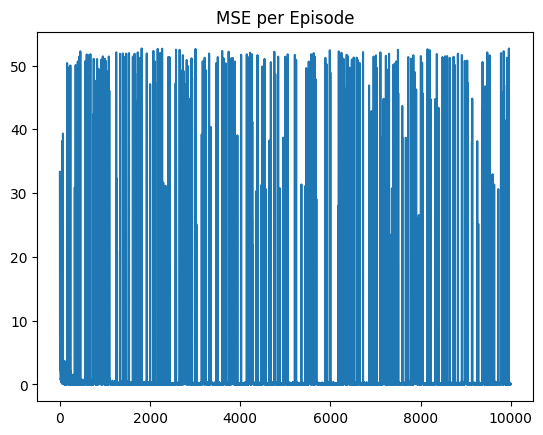

TypeError: ignored

In [18]:
if __name__ == '__main__':

  gridworld = create_gridworld()
  transition_probs, rewards = get_transition_probs_and_rewards(gridworld)

  # print rewards
  print("rewards:")
  print_values(gridworld.rewards, gridworld)
  print()

  # state -> action
  # we'll randomly choose an action and update as we learn
  policy = {}
  for state in gridworld.actions.keys():
    policy[state] = np.random.choice(ACTION_SPACE)

  # initial policy
  print("initial policy:")
  print_policy(policy, gridworld)
  print()

  # repeat until convergence - will break out when policy does not change
  value_function = None
  while True:

    # policy evaluation step - we already know how to do this!
    value_function = evaluate_deterministic_policy(gridworld, policy, value_function_=value_function)

    # policy improvement step
    is_policy_converged = True
    for state in gridworld.actions.keys():
      old_action = policy[state]
      new_action = None
      best_value = float('-inf')

      # loop through all possible actions to find the best current action
      for action in ACTION_SPACE:
        value = 0
        for new_state in gridworld.all_states():
          # reward is a function of (s, a, s'), 0 if not specified
          reward = rewards.get((state, action, new_state), 0)
          value += transition_probs.get((state, action, new_state), 0) * (reward + DISCOUNT_FACTOR * value_function[new_state])

        if value > best_value:
          best_value = value
          new_action = action

      # new_a now represents the best action in this state
      policy[state] = new_action
      if new_action != old_action:
        is_policy_converged = False

    if is_policy_converged:
      break

  # once we're done, print the final policy and values
  print("values:")
  print_values(value_function, gridworld)
  print()
  print("policy:")
  print_policy(policy, gridworld)
  print()

Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000


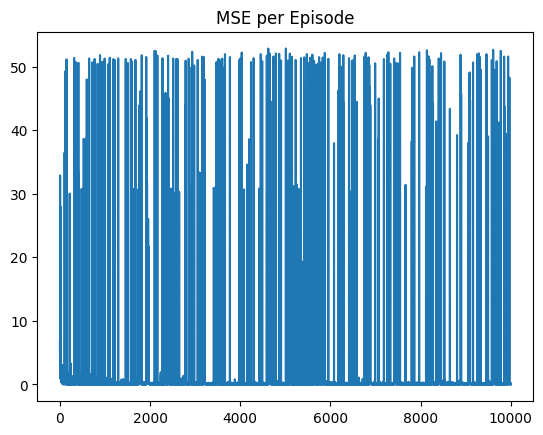

values:
---------------------------
 0.00| 0.00| 0.15| 0.00| 0.00| 2.29| 0.00| 2.17| 0.00| 4.02|
---------------------------
-0.88| 0.00| 0.00| 0.00| 5.99| 0.00| 9.74| 0.00| 0.00| 2.65|
---------------------------
 0.00| 0.00| 5.49| 6.21| 6.96| 7.82| 8.81| 0.00| 1.34| 0.00|
---------------------------
 3.72| 4.29| 4.89| 5.38| 6.00| 6.74| 0.00| 0.00| 0.00|-0.46|
---------------------------
 0.00| 3.84| 0.00| 0.00| 3.60| 3.55| 0.00| 0.00|-0.38|-0.58|
---------------------------
 2.90| 3.33| 2.87| 1.12| 0.00| 0.00| 0.00|-1.90|-0.41|-0.58|
---------------------------
 2.63| 0.00| 0.00| 0.00| 0.00| 0.00|-1.34| 0.47|-0.21| 0.00|
---------------------------
 2.32| 0.00|-2.54|-0.17|-0.13|-0.42| 0.00| 0.00|-1.14|-1.02|
---------------------------
 2.03| 1.53| 0.15|-1.46| 0.00|-1.07|-0.50|-2.16| 0.00|-0.97|
---------------------------
 1.67| 1.40| 0.00|-3.72|-2.55|-1.97|-0.10| 0.00|-0.31|-3.64|

policy:
---------------------------
     |     |  U  |     |     |  U  |     |  D  |     |  U  |
----

In [20]:
  model = RLModel(gridworld)
  mse_per_episode = []

  n_episodes = 10000

  for it in range(n_episodes):
    if it % 1000 == 0:
      print(f"Iteration: {it}")

    state = gridworld.reset()
    value_state = model.predict(state)
    n_steps = 0
    episode_error = 0

    while not gridworld.game_over():
      action = epsilon_greedy(policy, state)
      reward = gridworld.move(action)
      next_state = gridworld.current_state()

      if gridworld.is_terminal(next_state):
        target = reward
      else:
        value_next_state = model.predict(next_state)
        target = reward + DISCOUNT_FACTOR * value_next_state

      gradient = model.grad(state)
      error = target - value_state
      model.w += LR * error * gradient

      # accumulate error
      n_steps += 1
      episode_error += error ** 2

      # update state
      state = next_state
      value_state = value_next_state

    mse = episode_error / n_steps
    mse_per_episode.append(mse)

  plt.plot(mse_per_episode)
  plt.title("MSE per Episode")
  plt.show();

  # obtain predicted values
  value_function = {}
  states = gridworld.all_states()
  for state in states:
    if gridworld.is_terminal(state):
      value_function[state] = 0
    else:
      value_function[state] = model.predict(state)

  # once we're done, print the final policy and values
  print("values:")
  print_values(value_function, gridworld)
  print()
  print("policy:")
  print_policy(policy, gridworld)
  print()